# 1. Layout of the Model
## (need to change the path to see the results)

The empirical analysis in this paper is based on survey data from the IPUMS USA, providing detailed 
information on U.S. individuals. This dataset offers a representative sample of the U.S. population, 
including demographic, economic, and health-related characteristics, making it a valuable resource for 
analyzing the impact of policy changes like Medicaid expansion. 
Several key variables were added to the dataset related to health insurance coverage, Medicaid 
enrollment, and socioeconomic characteristics such as income, education, employment status, and 
race/ethnicity. Including these variables, it is possible to evaluate the impact of Medicaid expansion on 
health insurance coverage, as they allow us to control for complex factors. The sample starts in 2011 and 
ends in 2017. 

In [18]:
import numpy as np
import pandas as pd
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt


# Medicaid expansion years dictionary
medicaid_expansion_years = {
    1: np.nan,  2: 2015,  4: 2014,  5: 2014,  6: 2014,  8: 2014,  9: 2014,  10: 2014,  11: 2014,
    12: np.nan, 13: np.nan, 15: 2014, 16: 2020, 17: 2014, 18: 2015, 19: 2014, 20: np.nan, 21: 2014,
    22: 2016, 23: 2019, 24: 2014, 25: 2014, 26: 2014, 27: 2014, 28: np.nan, 29: 2021, 30: 2016,
    31: 2020, 32: 2014, 33: 2014, 34: 2014, 35: 2014, 36: 2014, 37: 2023, 38: 2014, 39: 2014,
    40: 2021, 41: 2014, 42: 2015, 44: 2014, 45: np.nan, 46: 2023, 47: np.nan, 48: np.nan, 49: 2020,
    50: 2014, 51: 2019, 53: 2014, 54: 2014, 55: np.nan, 56: np.nan
}

# Loading the dataset (path is needed to be changed here)
df = pd.read_csv(r"C:\Users\user\Desktop\usa_00019.csv")

# Adding Medicaid expansion status
df['Medicaid_expansion'] = df['STATEFIP'].map(lambda x: 1 if pd.notna(medicaid_expansion_years.get(x)) else 0)

# Filtering for three states that expanded Medicaid in 2014 and three that did not
expanded_states = [53, 41, 32, 6, 8, 4, 35, 38, 19, 27, 17, 5, 26, 39, 21, 54, 36, 50, 33, 11, 25, 44, 9, 34, 10, 24]  # Example: CA, CO, CT
non_expanded_states = [1, 13, 28, 45, 47, 12, 48, 20, 56, 55]  
df_subset = df[df['STATEFIP'].isin(expanded_states + non_expanded_states)].copy()

# Defining the post-treatment variable
df_subset.loc[:, 'POST_TREATMENT'] = df_subset['YEAR'].apply(lambda x: 1 if x >= 2014 else 0)

# Ensuring outcome variables are binary
df_subset.loc[:, 'HCOVANY'] = df_subset['HCOVANY'].apply(lambda x: 1 if x == 2 else 0)
df_subset.loc[:, 'HINSCAID'] = df_subset['HINSCAID'].apply(lambda x: 1 if x == 2 else 0)

# Creating the DiD interaction term
df_subset.loc[:, 'DID'] = df_subset['Medicaid_expansion'] * df_subset['POST_TREATMENT']

# Filtering for individuals with poverty between 100% and 300%
df_subset = df_subset[(df_subset['POVERTY'] >= 100) & (df_subset['POVERTY'] <= 300)]

# Transforming SEX into binary
df_subset = df_subset[df_subset['SEX'].isin([1, 2])]  # Keep valid SEX values
df_subset.loc[:, 'SEX'] = df_subset['SEX'].apply(lambda x: 0 if x == 1 else 1)

# Simplifying RACE variable
df_subset.loc[:, 'RACE'] = df_subset['RACE'].replace({
    1: 'White',
    2: 'Black',
    4: 'Asian',  # Combine Asian groups
    5: 'Asian',
    6: 'Asian',
    3: 'Other',  # Combine other races
    7: 'Other',
    8: 'Other',
    9: 'Other'
})

# Simplifying EDUC variable
df_subset.loc[:, 'EDUC'] = df_subset['EDUC'].replace({
    0: 'No schooling',
    1: 'No schooling',     
    2: 'Less than high school',
    3: 'Less than high school',
    4: 'Less than high school',
    5: 'Less than high school',
    6: 'High school',
    7: 'Some college',
    8: 'Some college',
    9: 'Some college',
    10: 'College graduate',
    11: 'Postgraduate'
})

# Filtering EMPSTAT to retain valid values
df_subset = df_subset[df_subset['EMPSTAT'].isin([1, 2, 3])]

# Dropping rows with any missing values
df_subset = df_subset.dropna()




# 4. Descriptive Statistics

In [ ]:
# List of expected variables
variables = ['HCOVANY', 'HINSCAID', 'AGE', 'Medicaid_expansion', 'POST_TREATMENT', 'DID']

# Filter the list to include only variables that exist in the dataset
existing_variables = [var for var in variables if var in df.columns]

# Create a summary statistics table for existing variables
summary_stats = df[existing_variables].describe(include='all').transpose()

# Add additional statistics
summary_stats['missing'] = df[existing_variables].isnull().sum()  # Count missing values
summary_stats['unique'] = df[existing_variables].nunique()  # Count unique values (categorical variables)
summary_stats = summary_stats[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'missing', 'unique']]

# Print the summary statistics
print(summary_stats)

# Save to CSV
summary_stats.to_csv("summary_statistics.csv", index=True)


                       count       mean        std   min   25%   50%   75%  \
HCOVANY             114553.0   1.846447   0.360522   1.0   2.0   2.0   2.0   
HINSCAID            114553.0   1.127103   0.333089   1.0   1.0   1.0   1.0   
AGE                 114553.0  43.587073  12.703025  21.0  33.0  45.0  55.0   
Medicaid_expansion  114553.0   0.737266   0.440121   0.0   0.0   1.0   1.0   

                     max  missing  unique  
HCOVANY              2.0        0       2  
HINSCAID             2.0        0       2  
AGE                 64.0        0      44  
Medicaid_expansion   1.0        0       2  


In [ ]:
# Simplify RACE variable
df['RACE'] = df['RACE'].replace({
    1: 'White',
    2: 'Black',
    4: 'Asian',  # Combine Asian groups
    5: 'Asian',
    6: 'Asian',
    3: 'Other',  # Combine other races
    7: 'Other',
    8: 'Other',
    9: 'Other'
})
# Clarify POVERTY as percentage of federal poverty line
df.rename(columns={'POVERTY': 'POVERTY_PERCENT'}, inplace=True)


# Simplify EDUC variable into broader categories
df['EDUC'] = df['EDUC'].replace({
    'No schooling': 'Low',
    'Less than high school': 'Low',
    'High school': 'Medium',
    'Some college': 'Medium',
    'College graduate': 'High',
    'Postgraduate': 'High'
})
# Check distribution of RACE
print(df['RACE'].value_counts())




RACE
White    87586
Black    12465
Other     8078
Asian     6424
Name: count, dtype: int64


In [ ]:
# Check distribution of EDUC
print(df['EDUC'].value_counts())

# Check summary statistics for POVERTY_PERCENT
print(df['POVERTY_PERCENT'].describe())

EDUC
6     40198
10    22987
7     18061
11    12770
8     10120
2      2663
5      2328
4      1893
3      1534
0      1480
1       519
Name: count, dtype: int64
count    114553.000000
mean        320.100399
std         171.154901
min           0.000000
25%         175.000000
50%         344.000000
75%         501.000000
max         501.000000
Name: POVERTY_PERCENT, dtype: float64


In [ ]:
# Check the distribution of SEX (1 = Male, 2 = Female)
sex_distribution = df['SEX'].value_counts()

# Rename for clarity
sex_distribution.index = ['Male', 'Female']

# Display the distribution
print("Distribution of Men and Women:")
print(sex_distribution)

# Calculate proportions
sex_proportion = sex_distribution / sex_distribution.sum() * 100
print("\nProportions of Men and Women (%):")
print(sex_proportion)


Distribution of Men and Women:
Male      58129
Female    56424
Name: count, dtype: int64

Proportions of Men and Women (%):
Male      50.744197
Female    49.255803
Name: count, dtype: float64


In [ ]:
# Check the distribution of EMPSTAT
employment_distribution = df['EMPSTAT'].value_counts()

# Rename for clarity
employment_labels = {1: 'Employed', 2: 'Unemployed', 3: 'Not in Labor Force'}
employment_distribution.index = [employment_labels.get(x, f"Unknown ({x})") for x in employment_distribution.index]

# Display the distribution
print("Distribution of Employment Status:")
print(employment_distribution)

# Calculate proportions
employment_proportion = employment_distribution / employment_distribution.sum() * 100
print("\nProportions of Employment Status (%):")
print(employment_proportion)


Distribution of Employment Status:
Employed              81174
Not in Labor Force    27966
Unemployed             5413
Name: count, dtype: int64

Proportions of Employment Status (%):
Employed              70.861523
Not in Labor Force    24.413154
Unemployed             4.725324
Name: count, dtype: float64


In [ ]:
# Check the distribution of HCOVANY and HINSCAID
hcovany_distribution = df['HCOVANY'].value_counts()
hinscaid_distribution = df['HINSCAID'].value_counts()

# Rename for clarity
coverage_labels = {1: 'Not Covered', 2: 'Covered'}
hcovany_distribution.index = [coverage_labels.get(x, f"Unknown ({x})") for x in hcovany_distribution.index]
hinscaid_distribution.index = [coverage_labels.get(x, f"Unknown ({x})") for x in hinscaid_distribution.index]

# Display distributions
print("Distribution of Health Insurance Coverage (HCOVANY):")
print(hcovany_distribution)

print("\nDistribution of Medicaid Coverage (HINSCAID):")
print(hinscaid_distribution)

# Calculate proportions
hcovany_proportion = hcovany_distribution / hcovany_distribution.sum() * 100
hinscaid_proportion = hinscaid_distribution / hinscaid_distribution.sum() * 100

print("\nProportions of Health Insurance Coverage (HCOVANY) (%):")
print(hcovany_proportion)

print("\nProportions of Medicaid Coverage (HINSCAID) (%):")
print(hinscaid_proportion)


Distribution of Health Insurance Coverage (HCOVANY):
Covered        96963
Not Covered    17590
Name: count, dtype: int64

Distribution of Medicaid Coverage (HINSCAID):
Not Covered    99993
Covered        14560
Name: count, dtype: int64

Proportions of Health Insurance Coverage (HCOVANY) (%):
Covered        84.644662
Not Covered    15.355338
Name: count, dtype: float64

Proportions of Medicaid Coverage (HINSCAID) (%):
Not Covered    87.289726
Covered        12.710274
Name: count, dtype: float64


In the 
USA,  a significant majority (85%) of people are insured. It is clear that only 13% of individuals are 
enrolled in Medicaid. The average age off the population is 44 years old, ranging from 21 to 64. The 
majority of individuals identify as White (76%), which is followed by Black (11%). Educational 
attainment varies, with 35% having completed high school, 25% having attended some college, and 
others. The gender distribution of the dataset is almost split 50/50. The majority of individuals are 
employed (71%), while 24% are not in the labour force and 5% are unemployed. Poverty levels range 
from 0% to 501%. These different characteristics will help us understand how Medicaid expansion 
influence different population subgroups in the country. 

# 2. Running Regressions

In [3]:
# Baseline DiD model for HCOVANY (no controls)
baseline_model_coverage = ols("HCOVANY ~ Medicaid_expansion + POST_TREATMENT + DID", data=df_subset).fit()
# Print baseline results for HCOVANY
print("Baseline Health Insurance Coverage Model (No Controls):")
print(baseline_model_coverage.summary())


Baseline Health Insurance Coverage Model (No Controls):
                            OLS Regression Results                            
Dep. Variable:                HCOVANY   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     252.0
Date:                Sun, 01 Dec 2024   Prob (F-statistic):          2.79e-161
Time:                        18:33:24   Log-Likelihood:                -14728.
No. Observations:               26582   AIC:                         2.946e+04
Df Residuals:                   26578   BIC:                         2.950e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------

In [4]:
# Baseline DiD model for HINSCAID (no controls)
baseline_model_medicaid = ols("HINSCAID ~ Medicaid_expansion + POST_TREATMENT + DID", data=df_subset).fit()
# Print baseline results for HINSCAID
print("\nBaseline Medicaid Coverage Model (No Controls):")
print(baseline_model_medicaid.summary())


Baseline Medicaid Coverage Model (No Controls):
                            OLS Regression Results                            
Dep. Variable:               HINSCAID   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     293.4
Date:                Sun, 01 Dec 2024   Prob (F-statistic):          2.21e-187
Time:                        18:33:25   Log-Likelihood:                -11894.
No. Observations:               26582   AIC:                         2.380e+04
Df Residuals:                   26578   BIC:                         2.383e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

Prior to Medicaid expansion, 67.36% of people in non-expansion states had health insurance, compared 
to 4.27 percentage points more in expansion states, according to the baseline Difference-in-Differences 
model. Overall, health insurance coverage rose by 9.31 percentage points after 2014, with expansion 
states seeing an additional 5.08 percentage point gain in coverage relative to non-expansion states as a 
result of the policy. In the fully adjusted model, these effects—including the impact of the Medicaid 
expansion—remained statistically significant. 

In [5]:
# Full DiD model for HCOVANY (with controls)
full_model_coverage = ols("HCOVANY ~ Medicaid_expansion + POST_TREATMENT + DID + EDUC + EMPSTAT + AGE + SEX + RACE", data=df_subset).fit()
# Print full results for HCOVANY
print("\nFull Health Insurance Coverage Model (With Controls):")
print(full_model_coverage.summary())


Full Health Insurance Coverage Model (With Controls):
                            OLS Regression Results                            
Dep. Variable:                HCOVANY   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     160.7
Date:                Sun, 01 Dec 2024   Prob (F-statistic):               0.00
Time:                        18:33:25   Log-Likelihood:                -14020.
No. Observations:               26582   AIC:                         2.807e+04
Df Residuals:                   26567   BIC:                         2.819e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------

In [6]:
# Full DiD model for HINSCAID (with controls)
full_model_medicaid = ols("HINSCAID ~ Medicaid_expansion + POST_TREATMENT + DID + EDUC + EMPSTAT + AGE + SEX + RACE", data=df_subset).fit()
# Print full results for HINSCAID
print("\nFull Medicaid Coverage Model (With Controls):")
print(full_model_medicaid.summary())


Full Medicaid Coverage Model (With Controls):
                            OLS Regression Results                            
Dep. Variable:               HINSCAID   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     191.0
Date:                Sun, 01 Dec 2024   Prob (F-statistic):               0.00
Time:                        18:33:25   Log-Likelihood:                -11052.
No. Observations:               26582   AIC:                         2.213e+04
Df Residuals:                   26567   BIC:                         2.226e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

According to the Full Health Insurance Coverage Model, Medicaid expansion and the post-treatment 
period are important factors that increase coverage rates by 4.91 and 8.97 percentage points, respectively. 
The interaction term (DID) also contributes an extra 4.86 percentage points to the increase in coverage 
rates. A distinct gradient in educational attainment is evident, with lower education levels (such as not 
attending school or having completed less than high school) being linked to noticeably lower coverage 
rates as compared to the reference group (College graduates). Gender and age also have an impact; 
women and older people have greater rates of health insurance coverage. After adjusting for other factors, 
the coefficients for race show variations in coverage compared to the reference group (Asian), with Black 
people having somewhat better coverage and those in the "Other" category having lower coverage. 
With a significant DID impact of 10.85 percentage points, Medicaid expansion raised Medicaid coverage 
by 5.47 percentage points in the Full Medicaid Coverage Model, while the post-treatment period added 
1.78 percentage points. Higher Medicaid coverage was linked to lower educational attainment, which 
might be a reflection of the program's emphasis on economically disadvantaged groups. In comparison 
to the reference group, racial disparities were found, with White people having somewhat lower Medicaid 
coverage and Black people having higher coverage. Medicaid coverage was negatively impacted by age, 
but higher coverage rates were linked to female gender and work status. These findings demonstrate 
complex relationships across racial and socioeconomic categories and emphasize the significance of 
Medicaid expansion and demographic factors in determining coverage patterns. 

# 3. Event Study 

                            OLS Regression Results                            
Dep. Variable:                HCOVANY   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     110.0
Date:                Sun, 01 Dec 2024   Prob (F-statistic):          1.30e-159
Time:                        18:33:25   Log-Likelihood:                -14721.
No. Observations:               26582   AIC:                         2.946e+04
Df Residuals:                   26574   BIC:                         2.952e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.6737      0

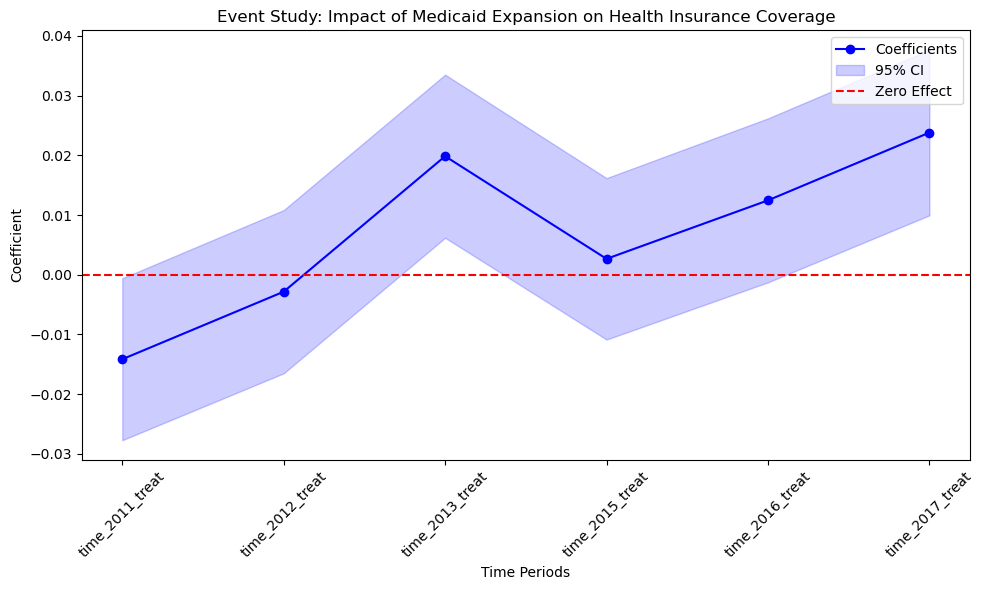

In [7]:
# Create time dummies
time_dummies = pd.get_dummies(df_subset['YEAR'], prefix='time')

# Add time dummies to the DataFrame
df_subset = pd.concat([df_subset, time_dummies], axis=1)

# Create interaction terms
for col in time_dummies.columns:
    df_subset[f'{col}_treat'] = df_subset[col] * df_subset['Medicaid_expansion']
# Define the formula for the event study model
formula = 'HCOVANY ~ Medicaid_expansion + POST_TREATMENT + DID + ' + ' + '.join([f'{col}_treat' for col in time_dummies.columns])

# Estimate the model
event_study_model = ols(formula, data=df_subset).fit()

# Print the summary of the model
print(event_study_model.summary())

# Filter coefficients and confidence intervals for interaction terms
coefficients = event_study_model.params.filter(like='_treat')
conf_int = event_study_model.conf_int().loc[coefficients.index]  # Match rows with coefficients

# Debugging: Check the structure of coefficients and confidence intervals
print("Coefficients:")
print(coefficients)
print("Confidence Intervals:")
print(conf_int)

# Extract lower and upper bounds for plotting
lower_bound = conf_int[0]  # First column of conf_int
upper_bound = conf_int[1]  # Second column of conf_int

# Plot the event study results
plt.figure(figsize=(10, 6))
plt.plot(coefficients.index, coefficients.values, marker='o', linestyle='-', color='b', label='Coefficients')
plt.fill_between(coefficients.index, lower_bound, upper_bound, color='b', alpha=0.2, label='95% CI')
plt.axhline(y=0, color='r', linestyle='--', label='Zero Effect')
plt.xlabel('Time Periods')
plt.ylabel('Coefficient')
plt.title('Event Study: Impact of Medicaid Expansion on Health Insurance Coverage')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


This event study examines the impact of Medicaid expansion on health insurance coverage across 
multiple time periods. Figure 1 reveals a significant increase in health insurance coverage following 
Medicaid expansion, particularly in the later post-treatment years (2017). Before the expansion (2011–
2012), there were no significant differences in coverage between treated and control states, as indicated 
by the near-zero coefficients. However, a slight positive trend is observed in 2013, potentially reflecting 
other factors. In the earlier post-treatment years (2015–2016), the impact was less pronounced. These 
findings suggest that Medicaid expansion increased health insurance coverage, especially in the long 
term, while pre-treatment trends provide general support for the parallel trends assumption. 

In [17]:
# List of expected variables
variables = ['HCOVANY', 'HINSCAID', 'AGE', 'SEX', 'RACE', 'EDUC', 'EMPSTAT', 'POVERTY', 'Medicaid_expansion', 'POST_TREATMENT', 'DID']

# Filter the list to include only variables that exist in the dataset
existing_variables = [var for var in variables if var in df.columns]

# Create a summary statistics table for existing variables
summary_stats = df[existing_variables].describe(include='all').transpose()

# Add additional statistics
summary_stats['missing'] = df[existing_variables].isnull().sum()  # Count missing values
summary_stats['unique'] = df[existing_variables].nunique()  # Count unique values (categorical variables)
summary_stats = summary_stats[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'missing', 'unique']]

# Print the summary statistics
print(summary_stats)

# Save to CSV
summary_stats.to_csv("summary_statistics.csv", index=True)


                       count       mean        std   min   25%   50%   75%  \
HCOVANY             114553.0   1.846447   0.360522   1.0   2.0   2.0   2.0   
HINSCAID            114553.0   1.127103   0.333089   1.0   1.0   1.0   1.0   
AGE                 114553.0  43.587073  12.703025  21.0  33.0  45.0  55.0   
SEX                 114553.0   1.507442   0.499947   1.0   1.0   2.0   2.0   
RACE                  114553        NaN        NaN   NaN   NaN   NaN   NaN   
EDUC                114553.0   7.407698   2.384185   0.0   6.0   7.0  10.0   
EMPSTAT             114553.0   1.535516   0.858492   1.0   1.0   1.0   2.0   
Medicaid_expansion  114553.0   0.737266   0.440121   0.0   0.0   1.0   1.0   

                     max  missing  unique  
HCOVANY              2.0        0       2  
HINSCAID             2.0        0       2  
AGE                 64.0        0      44  
SEX                  2.0        0       2  
RACE                 NaN        0       4  
EDUC                11.0        0

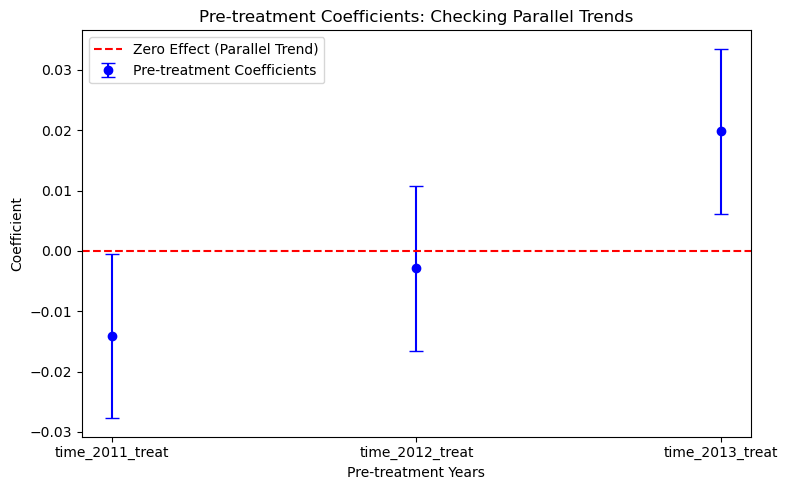

F-test results for parallel trends assumption:
<F test: F=0.2235187768200969, p=0.6363756504594045, df_denom=2.66e+04, df_num=1>


In [11]:
# Extract pre-treatment coefficients from the event study model
pre_treatment_coefficients = coefficients.filter(like='time_20').loc[['time_2011_treat', 'time_2012_treat', 'time_2013_treat']]
pre_treatment_conf_int = conf_int.loc[['time_2011_treat', 'time_2012_treat', 'time_2013_treat']]

# Visual Inspection: Plot pre-treatment coefficients
plt.figure(figsize=(8, 5))
plt.errorbar(pre_treatment_coefficients.index, pre_treatment_coefficients.values, 
             yerr=[pre_treatment_coefficients.values - pre_treatment_conf_int.iloc[:, 0],
                   pre_treatment_conf_int.iloc[:, 1] - pre_treatment_coefficients.values],
             fmt='o', capsize=5, label='Pre-treatment Coefficients', color='blue')
plt.axhline(0, color='red', linestyle='--', label='Zero Effect (Parallel Trend)')
plt.title('Pre-treatment Coefficients: Checking Parallel Trends')
plt.xlabel('Pre-treatment Years')
plt.ylabel('Coefficient')
plt.legend()
plt.tight_layout()
plt.show()

# Formal Statistical Test: Joint Hypothesis Test
# Null hypothesis: Pre-treatment coefficients are jointly equal to zero
# Subset the event study model to include only pre-treatment years
pre_treatment_years = ['time_2011_treat', 'time_2012_treat', 'time_2013_treat']
subset_formula = f'HCOVANY ~ Medicaid_expansion + POST_TREATMENT + DID + ' + ' + '.join(pre_treatment_years)
pre_treatment_model = ols(subset_formula, data=df_subset).fit()

# Perform F-test to check joint significance of pre-treatment coefficients
f_test = pre_treatment_model.f_test(" + ".join(pre_treatment_years) + " = 0")
print("F-test results for parallel trends assumption:")
print(f_test)

We conduct the parallel trends assumption check using a pre-treatment analysis. The coefficients for both 
2011 and 2012 are close to zero, with confidence intervals overlapping zero, indicating no statistically 
significant differences between the treatment and control groups. The F-test (F = 0.22, p = 0.64) confirms 
no significant differences in pre-treatment trends. These findings suggest that the treatment and control 
groups were comparable prior to the Medicaid expansion. 